In [103]:
import os
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [70]:
import tiktoken
# encoder = tiktoken.get_encoding("cl100k_base") # openai encoder

from transformers import AutoTokenizer
encoder = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

In [12]:
files = os.listdir("AllSidesArticles/")

In [13]:
with open(f"AllSidesArticles/{files[0]}") as f:
        s = json.load(f)

In [14]:
articles = {}
for path in files:
    if path.endswith(".json"):
        with open(f"AllSidesArticles/{path}") as f:
            dic = json.load(f)
            title = dic.get("newsTitle")
            body = dic.get("fullArticle")
            if not body:
                continue
            else:
                body = "\n".join(body)
            articles[path[:-5]] = f"{title}\n{body}"

## Articles

In [71]:
len(articles)

2140

In [72]:
ids = set()
for key in articles.keys():
    ids.add(int(key.split('_')[0]))

In [73]:
len(ids)

846

In [74]:
toklens = {key: len(encoder.encode(text)) for key, text in articles.items()}

Token indices sequence length is longer than the specified maximum sequence length for this model (1535 > 1024). Running this sequence through the model will result in indexing errors


In [75]:
toklens = sorted(toklens.items(), key=lambda x: x[1], reverse=True)

In [76]:
toklens[:10] # 10 longest articles

[('4198_left', 9698),
 ('5188_left', 9549),
 ('2049_center', 8906),
 ('1831_left', 8292),
 ('5036_center', 7616),
 ('4440_center', 7277),
 ('4159_center', 6899),
 ('5142_center', 5742),
 ('4584_left', 5652),
 ('5177_left', 5640)]

In [77]:
toklens[-10:] # 10 shortest

[('2702_center', 107),
 ('1106_left', 104),
 ('4020_center', 97),
 ('2758_center', 93),
 ('2025_center', 88),
 ('2235_left', 82),
 ('4203_center', 80),
 ('2845_right', 61),
 ('3370_center', 50),
 ('4433_center', 31)]

In [78]:
articles['4433_center']

'Trump declares national emergency to bolster funding for fighting virus outbreak\nWASHINGTON (AP) — Trump declares national emergency to bolster funding for fighting virus outbreak.'

In [79]:
articles['3370_center']

'Republican Senator Collins says will vote to confirm Kavanaugh\nWASHINGTON (Reuters) - Republican U.S. Senator Susan Collins said on Friday she will vote to confirm the nomination of Brett Kavanaugh to the Supreme Court, strongly increasing his chances of confirmation.'

## token analysis

In [81]:
tkl_list = [x[1] for x in toklens]

In [88]:
min(sum_toks), max(sum_toks), sum(sum_toks)

(18, 519, 278575)

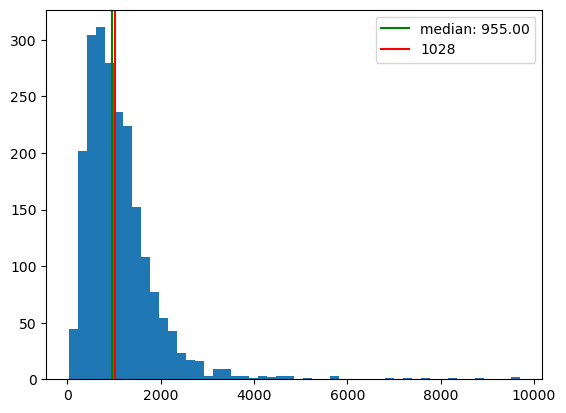

In [83]:
plt.hist(tkl_list, bins=50)
mean = np.mean(tkl_list)
median = np.median(tkl_list)
# plt.axvline(mean, label=f"mean: {mean:.2f}", color="yellow")
plt.axvline(median, label=f"median: {median:.2f}", color="green")
plt.axvline(1028, color="red", label="1028")
plt.legend()
plt.show()

=> most articles fit within 1028 BART max seq len

In [41]:
# 42% of articles with length > 1028
len([l for l in tkl_list if l > 1028]) / len(tkl_list)

0.4247663551401869

## GPT-4 Generated Target Summaries

In [84]:
summs = {}
fnames = os.listdir("Summaries")
for fn in fnames:
    with open(f"Summaries/{fn}") as f:
        summs[fn[:-4]] = f.read()

In [85]:
sum_toks = [len(encoder.encode(t)) for t in summs.values()]

In [88]:
min(sum_toks), max(sum_toks), sum(sum_toks)

(18, 519, 278575)

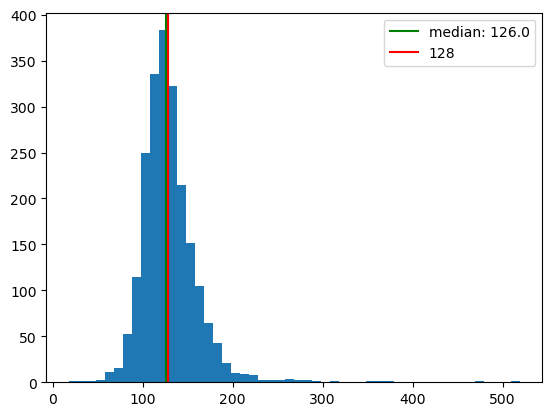

In [89]:
plt.hist(sum_toks, bins=50)
mean = np.mean(sum_toks)
med = np.median(sum_toks)
# plt.axvline(mean, label=f"mean: {mean:.2f}", color="yellow")
plt.axvline(med, label=f"median: {med}", color="green")
plt.axvline(128, label="128", color="red")
plt.legend()
plt.show()

=> most summaries fit within BART max target length (128)

## bias

In [98]:
left, center, right = 0,0,0
for name in articles.keys():
    id, bias = name.split("_")
    if bias == "left":
        left += 1
    elif bias == "center":
        center += 1
    elif bias == 'right':
        right += 1

[721, 713, 706]


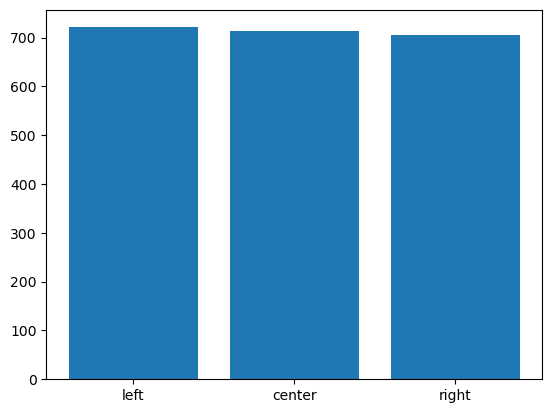

In [101]:
data = [left, center, right]
plt.bar(["left", 'center', 'right'], data)
print(data)

## pairs

In [108]:
pairs = defaultdict(set)
for name in articles.keys():
    id, bias = name.split('_')
    pairs[id].add(bias)

In [110]:
num_pairs = defaultdict(int)
for pair in pairs.values():
    num_pairs[tuple(pair)] += 1

In [114]:
num_pairs

defaultdict(int,
            {('center', 'left', 'right'): 540,
             ('left', 'right'): 66,
             ('center', 'left'): 80,
             ('right',): 32,
             ('center', 'right'): 68,
             ('center',): 25,
             ('left',): 35})